# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [3]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)


In [4]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,...,T,T10,TD,U,VV,WW,gasPower,dwelling,hour,dayofweek
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22,185.730438,0.0,243.831944,444.333333,8.236250,12.023750,7.388889,1005.554169,30.708333,1.112500,...,9.236111,8.973611,8.283333,93.319444,9911.805583,54.069444,0.256246,All dwellings,0,2
2017-02-23,173.374907,0.0,239.148194,265.916667,11.608438,17.165569,7.612500,995.103327,24.312500,0.461319,...,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,0.485713,All dwellings,0,3
2017-02-24,246.992340,0.0,278.093543,45.766667,5.032826,7.413604,4.665972,1011.765422,107.562499,0.054306,...,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,0.276830,All dwellings,0,4
2017-02-25,150.144606,0.0,202.265418,14.750000,6.502271,9.496715,6.166667,1016.465144,49.312501,0.002083,...,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.017166,All dwellings,0,5
2017-02-26,679.171475,0.0,208.350207,82.633334,7.540049,11.129507,7.694444,1008.878202,24.770834,0.098611,...,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,0.503001,All dwellings,0,6


Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

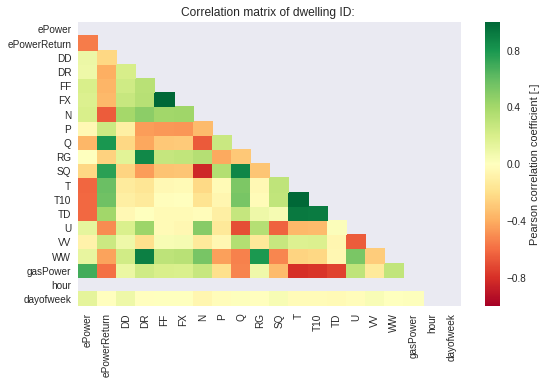

In [5]:
fig = create_corr_matrix(df, '', False)

# Select data to use

Saving heatmap
Len of data:  278


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

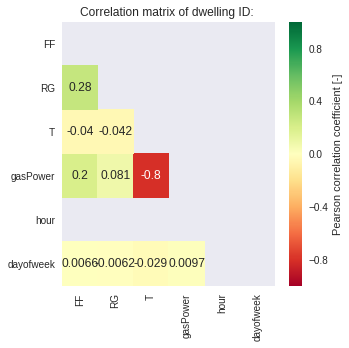

In [6]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

(array([736389., 736420., 736450., 736481., 736511., 736542., 736573.,
        736603., 736634., 736664.]), <a list of 10 Text xticklabel objects>)

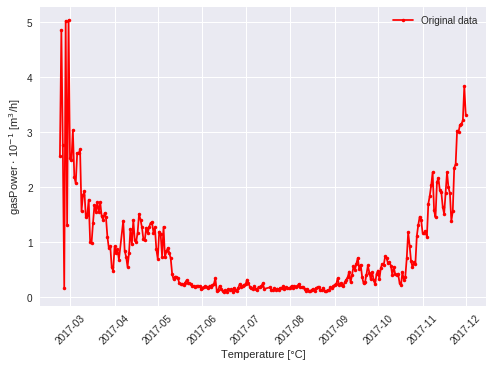

In [7]:
plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()
plt.xticks(rotation=45)

# Preprocessing

# Select summer data

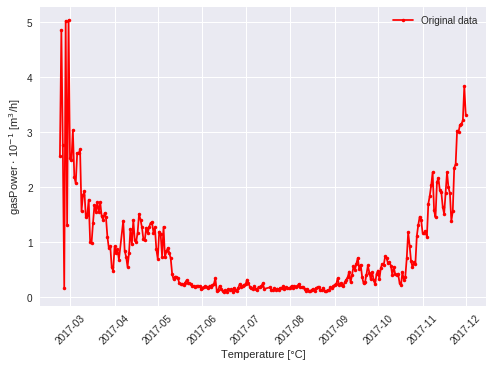

In [8]:
#data = data['2017-05-12':'2017-09-10']

plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.xticks(rotation=45)
plt.legend()

# Preprocessing, data to lstm format

In [9]:
data['gp'] = data['gasPower']
data = data.drop(columns=['gasPower'])
data.head()

,FF,RG,T,hour,dayofweek,gp
datetime,,,,,,
2017-02-22,8.236250,1.112500,9.236111,0,2,2.562459
2017-02-23,11.608438,0.461319,8.590000,0,3,4.857127
2017-02-24,5.032826,0.054306,4.746250,0,4,2.768300
2017-02-25,6.502271,0.002083,5.606806,0,5,0.171661
2017-02-26,7.540049,0.098611,8.688750,0,6,5.030009


In [10]:
data.values.shape

(278, 6)

In [11]:
# signal to lstm format
# source://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha

# Train/test and variable split
split = 0.5# 80% train, 20% test
split_idx = int(data.shape[0]*split)

In [12]:
# ...train
X_train = data.values[0:split_idx, 0:5]
y_train = data.values[0:split_idx, 5]

# ...test
X_test = data.values[split_idx:-1, 0:5]
y_test = data.values[split_idx:-1, 5]

# Scale the data
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

In [13]:
# Model setup
look_back = 5 # as that is how y was generated (i.e. sum last three steps)
num_features = 5 # in this case: 2 features x1, x2
output_dim = 1 # want to predict 1 y value

# Reshaping
nb_samples = len(X_train) # in this case 217 samples in the training set

####

nb_samples_train = X_train.shape[0] - look_back
X_train_reshaped = np.zeros((nb_samples_train, look_back, num_features))
y_train_reshaped = np.zeros((nb_samples_train))

for i in range(nb_samples_train):
    y_position = i + look_back
    X_train_reshaped[i] = X_train[i:y_position]
    y_train_reshaped[i] = y_train[y_position]


nb_samples_test = X_test.shape[0] - look_back
X_test_reshaped = np.zeros((nb_samples_test, look_back, num_features))
y_test_reshaped = np.zeros((nb_samples_test))

for i in range(nb_samples_test):
    y_position = i + look_back
    X_test_reshaped[i] = X_test[i:y_position]
    y_test_reshaped[i] = y_test[y_position]

X_test_reshaped.shape

(133, 5, 5)

In [14]:
def abs_percentage_error(y_true, y_pred):
    import keras.backend as K
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

In [50]:
nb_hidden_neurons = 35 # assume something to start with
nb_epoch = 1000 # assume something to start with

# Create model
model = Sequential()

model.add(LSTM(nb_hidden_neurons, input_shape=(look_back, num_features), kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())

model.add(Dense(35, kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())

N = 256 #45  
for i in range(4):
    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
    model.add(LeakyReLU())
    #model.add(Dropout(0.5))


model.add(Dense(units=output_dim, kernel_initializer='TruncatedNormal'))
#model.add(Activation('linear'))

model = multi_gpu_model(model, gpus=num_gpu)

sgd = SGD(lr=0.0001, momentum=0.1, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compile & fit
model.compile(optimizer=sgd, loss = ['mse'], metrics=['mse', abs_percentage_error])

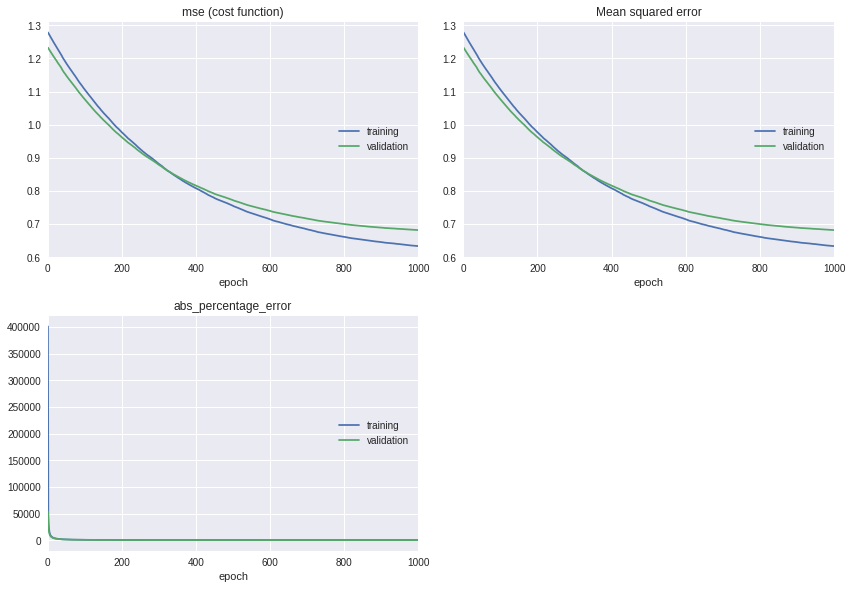

 - 0s - loss: 0.6331 - mean_squared_error: 0.6331 - abs_percentage_error: 91.8164 - val_loss: 0.6815 - val_mean_squared_error: 0.6815 - val_abs_percentage_error: 91.2201
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_13_input (InputLayer)      (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lambda_45 (Lambda)              (None, 5, 5)         0           lstm_13_input[0][0]              
__________________________________________________________________________________________________
lambda_46 (Lambda)              (None, 5, 5)         0           lstm_13_input[0][0]              
__________________________________________________________________________________________________
lambda_47 (Lambda)              (None,

In [51]:
early_stopping_monitor = EarlyStopping(patience=1000)



model.fit(X_train_reshaped, y_train_reshaped, epochs=nb_epoch, batch_size=int(len(X_train_reshaped)/4), validation_data=(X_test_reshaped, y_test_reshaped),
         verbose=2, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

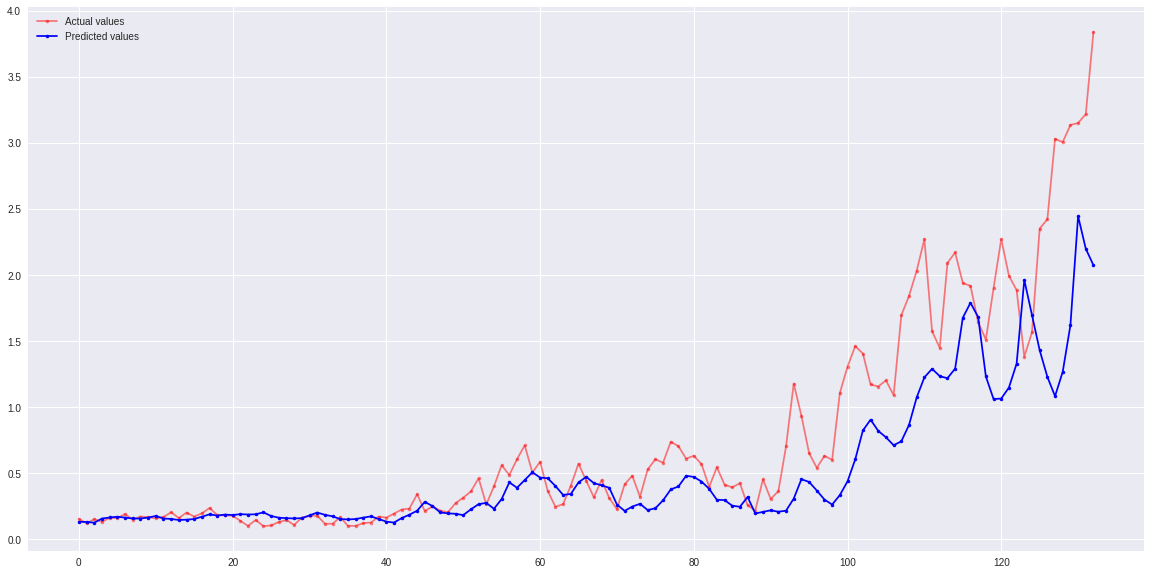

In [48]:
y_preds = model.predict(X_test_reshaped)
y_true = y_test_reshaped.reshape(y_test_reshaped.shape[0], 1)
x = np.arange(X_test_reshaped.shape[0])

plt.figure(figsize=(20,10))
plt.plot(x, y_true, '.-', color='r', label='Actual values', alpha=0.5)
plt.plot(x, y_preds, '.-', color='b', label='Predicted values')
plt.legend()